<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Classification

![](https://images.deepai.org/converted-papers/1909.04939/x4.png)

# Install

In [2]:
!pip install tslearn
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 793 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 2.7 MB/s 
     |████████████████████████████████| 9.8 MB 29.9 MB/s 
     |████████████████████████████████| 1.1 MB 39.6 MB/s 
     |████████████████████████████████| 136 kB 62.5 MB/s 
     |████████████████████████████████| 1.3 MB 39.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavio

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import itertools
import requests
import zipfile
import collections
from collections import Counter
from scipy.stats import mode

import xgboost as xgb
from xgboost import XGBClassifier

import tslearn
from tslearn.datasets import UCR_UEA_datasets
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import tsfresh
from tsfresh import select_features
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


# Data
* Dataset released in 2002
* Resource for Time Series Mining

In [2]:
X_train_raw, y_train, X_test_raw, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')

In [3]:
print(f'Training Set Size: {X_train_raw.shape}')
print(f'Test     Set Size: {X_test_raw.shape}')

Training Set Size: (1000, 128, 1)
Test     Set Size: (4000, 128, 1)


In [4]:
X_train = pd.DataFrame(np.squeeze(X_train_raw))
X_test  = pd.DataFrame(np.squeeze(X_test_raw))

## Classes & Balance

In [5]:
counter = Counter(y_train)
counter

Counter({2: 237, 3: 250, 4: 242, 1: 271})

## Plots

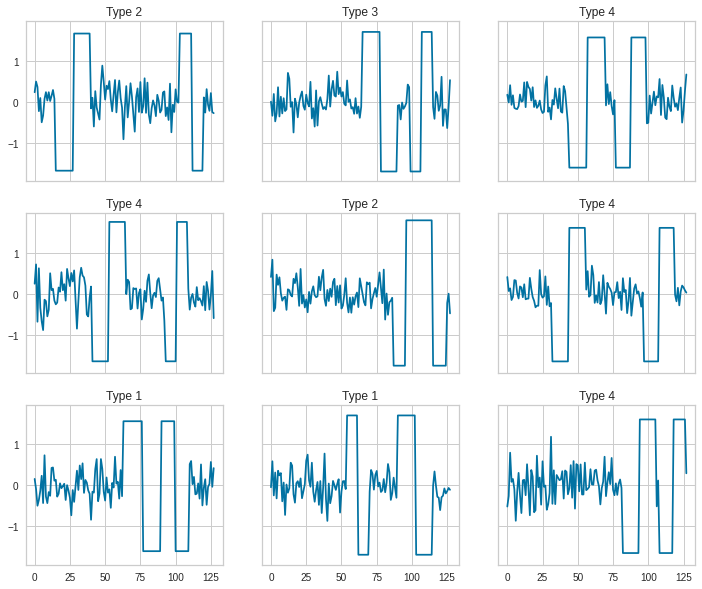

In [6]:
f, ax = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12, 10))
for index in range(9):
    ax[index // 3, index % 3].plot(X_train_raw[index])
    ax[index // 3, index % 3].set_title('Type {}'.format(y_train[index]))

## Histogram

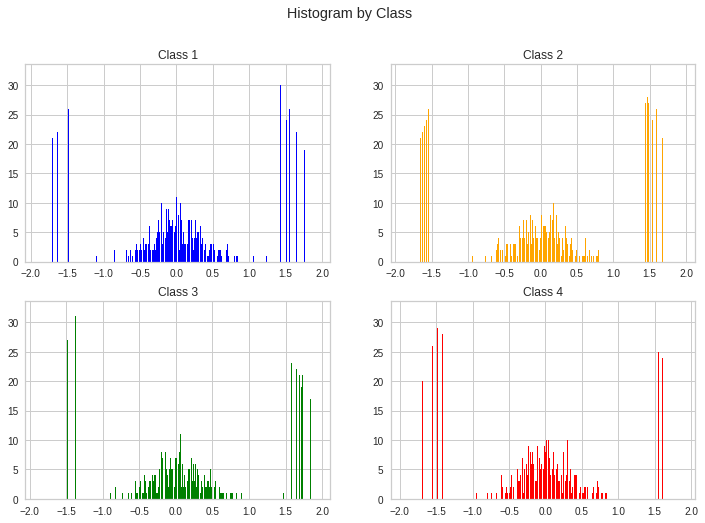

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Histogram by Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    length = (y_train == index + 1).sum()
    ax[x, y].hist(X_train[y_train == index + 1], color=([colors[index]] * length), bins=int(X_train.shape[1] / 2))
    ax[x, y].title.set_text(f'Class {index + 1}')

## 2D Histogram

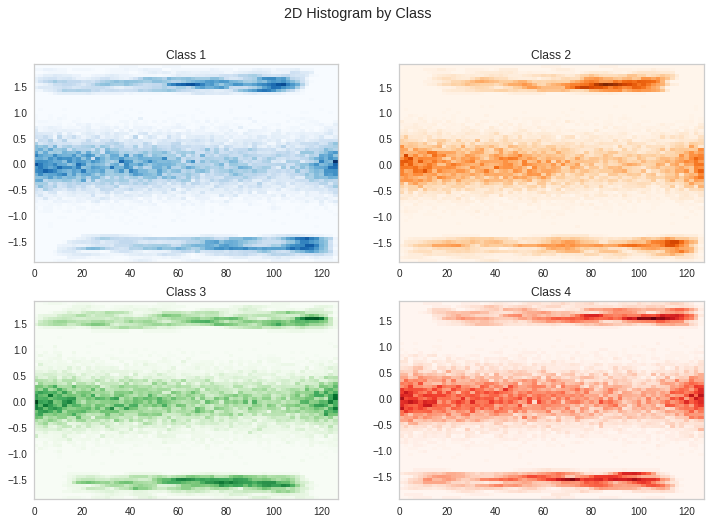

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('2D Histogram by Class')

colors = ['Blues', 'Oranges', 'Greens', 'Reds']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    melted = X_train[y_train == index + 1].melt()
    length = melted.shape[0]
    ax[x, y].hist2d(x = melted['variable'], y = melted['value'],
                    bins=int(X_train.shape[1] / 2), cmap=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

## Mean by Position

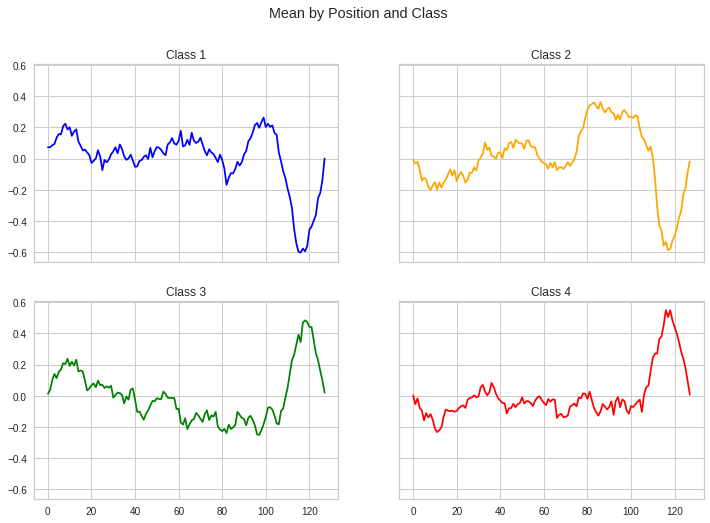

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('Mean by Position and Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    ax[x, y].plot(X_train[y_train == index + 1].mean(), color=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

## Variance by Position

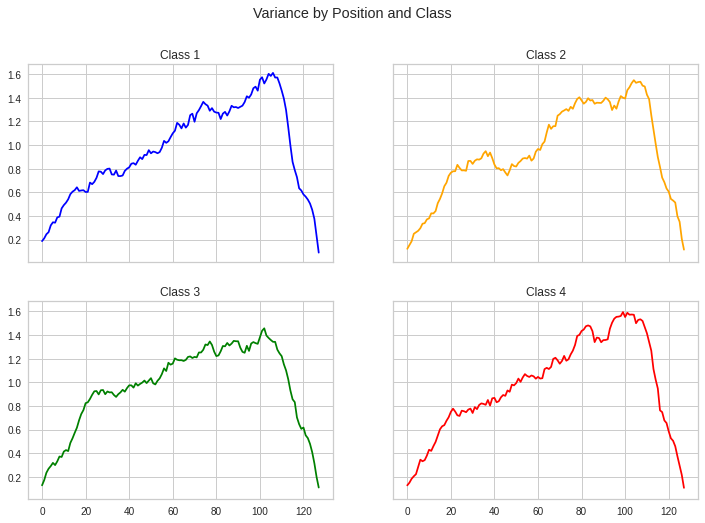

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12,8), sharex=True, sharey=True)
fig.suptitle('Variance by Position and Class')

colors = ['blue', 'orange', 'green', 'red']
for index in [0, 1, 2, 3]:
    x = index // 2
    y = index % 2
    ax[x, y].plot(X_train[y_train == index + 1].var(), color=colors[index])
    ax[x, y].title.set_text(f'Class {index + 1}')

# XGBoost

In [12]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [15]:
boost.fit(X_train, y_train)
pred = boost.predict(X_test)

[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[13:44:41] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nod

In [17]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.78      0.79      0.78      1035
           2       0.77      0.74      0.75      1011
           3       0.78      0.81      0.79       995
           4       0.79      0.78      0.78       959

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



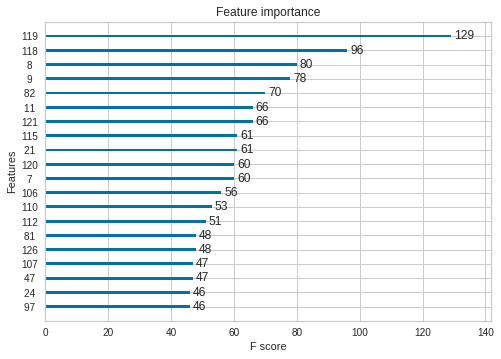

In [18]:
xgb.plot_importance(boost, max_num_features=20);

# Feature Generation
* Ergodic features will converge to stable values we add more data
  * More data = More understanding of the time series process
  * A random work, for example, does not have ergodicity
* If we used a sample of our timeseries to generate features:
  * We'd like those features to be similar if we generated them from a different sample
  * Ergodicity is weaker than stationarity
  * Stationarity means that the statistical properties will be the same

In [25]:
X_train_gen = X_train.copy()
X_test_gen  = X_test.copy()

## Mean & Variance

In [26]:
X_train_gen['mean'] = X_train_gen.iloc[:,0:128].mean(axis=1)
X_train_gen['mean20'] = X_train_gen.iloc[:,0:20].mean(axis=1)
X_train_gen['mean110'] = X_train_gen.iloc[:,110:128].mean(axis=1)
X_train_gen['variance'] = X_train_gen.iloc[:,0:128].var(axis=1)

X_test_gen['mean'] = X_test_gen.iloc[:,0:128].mean(axis=1)
X_test_gen['mean20'] = X_test_gen.iloc[:,0:20].mean(axis=1)
X_test_gen['mean110'] = X_test_gen.iloc[:,110:128].mean(axis=1)
X_test_gen['variance'] = X_test_gen.iloc[:,0:128].var(axis=1)

## Min and Max

In [27]:
X_train_gen['min'] = X_train_gen.iloc[:,0:128].min(axis=1)
X_train_gen['max'] = X_train_gen.iloc[:,0:128].max(axis=1)

X_test_gen['min'] = X_test_gen.iloc[:,0:128].min(axis=1)
X_test_gen['max'] = X_test_gen.iloc[:,0:128].max(axis=1)

## Points above Threshold

In [28]:
X_train_gen['above_pos1'] = (X_train_gen.iloc[:,0:128] > 1.0).sum(axis=1)
X_train_gen['below_neg1'] = (X_train_gen.iloc[:,0:128] < -1.0).sum(axis=1)

X_test_gen['above_pos1'] = (X_test_gen.iloc[:,0:128] > 1.0).sum(axis=1)
X_test_gen['below_neg1'] = (X_test_gen.iloc[:,0:128] < -1.0).sum(axis=1)

## Other Feature Ideas
* Periodicity
* Smoothness
* Autocorrelation

## Model

In [30]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [31]:
boost.fit(X_train_gen, y_train, verbose=True)
pred = boost.predict(X_test_gen)

[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[13:55:14] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nod

In [32]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           1       0.83      0.85      0.84      1035
           2       0.82      0.77      0.79      1011
           3       0.81      0.83      0.82       995
           4       0.79      0.80      0.79       959

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



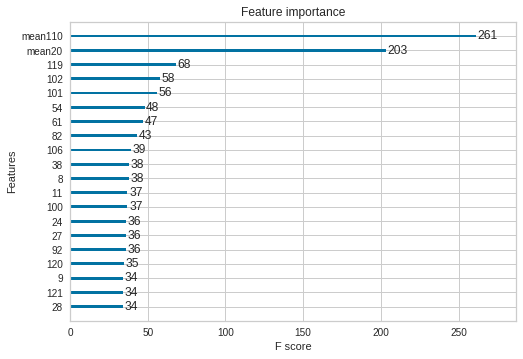

In [33]:
xgb.plot_importance(boost, max_num_features=20);

## Observations
* Using some of the visuals provided some insights
* Moved up from 77.8% to 81.1% accuracy
* Need deeper domain expertise to continue finding features to improve

# TSFresh
* Time Series FeatuRe Exraction based on Scalable Hypothesis
* Handles automatic
  * Feature Generation
  * Imputation of missing generated features
  * Statistical selection of features
* Other related library - Cesium

## Melting
* Our data is in wide format (training cases by time series 0-127)
* We need it in long format for processing by the tsfresh library
* This involves moving each row - column cell to its own row
  * Row 1 : case 0, series @ time 0
  * Row 2 : case 0, series @ time 1
  * ...
  * Row 127,999 : case 999 @ time 126
  * Row 127,999 : case 999 @ time 127

In [35]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.230379,0.490966,0.358833,-0.230965,0.090225,-0.501473,-0.339329,0.066836,0.232949,0.028326,...,-1.680129,-1.680129,0.105036,-0.264838,0.306594,-0.075228,-0.222192,0.210745,-0.255429,-0.278942
1,0.000765,-0.342680,0.188729,-0.479362,-0.281932,0.351927,-0.360330,0.121821,-0.285499,0.085623,...,0.148473,-0.221473,-0.090350,0.606164,-0.589216,-0.187478,-0.189875,-0.642700,-0.121495,0.525895
2,0.170442,-0.018864,0.402452,-0.075797,0.156014,-0.150981,-0.171141,-0.179950,-0.108274,0.175447,...,0.098403,-0.122188,-0.043269,-0.205324,0.093592,0.346100,-0.508802,-0.220517,0.257965,0.662665
3,0.239996,0.709401,-0.686034,0.615863,-0.345213,-0.677124,-0.890195,-0.150061,-0.183684,-0.555484,...,-0.185940,-0.291869,0.181239,-0.404985,0.282751,0.065136,-0.389442,-0.034956,0.548547,-0.599219
4,0.404257,0.824277,-0.427975,-0.345740,0.461754,0.211839,0.395389,0.009144,-0.173102,-0.102791,...,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-1.756405,-0.227913,-0.002611,-0.482962


In [37]:
X_train_fresh = X_train.copy()
X_train_fresh['id'] = X_train_fresh.index

X_test_fresh = X_test.copy()
X_test_fresh['id'] = X_test_fresh.index

In [38]:
X_train_melt = X_train_fresh.melt(id_vars=['id']).sort_values(['id', 'variable'])
X_test_melt  = X_test_fresh.melt(id_vars=['id']).sort_values(['id', 'variable'])

In [39]:
X_train_melt.head()

,id,variable,value
0,0,0,0.230379
1000,0,1,0.490966
2000,0,2,0.358833
3000,0,3,-0.230965
4000,0,4,0.090225


## Fresh
* http://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [42]:
extracted_features_train = extract_features(X_train_melt, column_id='id', column_sort='variable',
                                            default_fc_parameters = EfficientFCParameters())

Feature Extraction: 100%|██████████| 1000/1000 [01:04<00:00, 15.52it/s]


In [43]:
extracted_features_test = extract_features(X_test_melt, column_id='id', column_sort='variable',
                                            default_fc_parameters = EfficientFCParameters())

Feature Extraction: 100%|██████████| 4000/4000 [04:20<00:00, 15.33it/s]


In [44]:
extracted_features_train['id'] = extracted_features_train.index
extracted_features_test['id'] = extracted_features_test.index
extracted_features_train.head()

,value__variance_larger_than_standard_deviation,value__has_duplicate_max,value__has_duplicate_min,value__has_duplicate,value__sum_values,value__abs_energy,value__mean_abs_change,value__mean_change,value__mean_second_derivative_central,value__median,...,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7,id
0,0.0,1.0,1.0,1.0,3.767000e-07,126.999996,0.374073,-0.004010,-0.001127,0.026568,...,4.075583,NaN,1.224790,5.023241,3.165942,3.376425,1.898947,4.238907,1.680129,0
1,0.0,1.0,1.0,1.0,1.490500e-07,127.000005,0.346946,0.004135,0.003932,-0.056065,...,4.051888,NaN,0.909792,4.699131,2.953895,3.327430,2.029786,3.967540,1.699885,1
2,0.0,1.0,1.0,1.0,4.687000e-07,126.999996,0.292091,0.003876,0.002357,-0.022307,...,3.712500,NaN,1.280141,5.753528,3.222494,2.590577,2.101181,4.853228,1.605849,2
3,0.0,1.0,1.0,1.0,1.120000e-08,127.000003,0.347132,-0.006608,-0.006417,0.002170,...,4.016527,NaN,1.037501,4.889016,2.680241,2.399675,1.662922,3.868170,1.744717,3
4,0.0,1.0,1.0,1.0,1.367110e-06,127.000001,0.311313,-0.006986,-0.003573,-0.037720,...,3.982437,NaN,1.174749,5.656854,3.284183,3.514389,3.156694,3.762206,1.783656,4


## Combine

In [45]:
X_train_combined = pd.merge(X_train_fresh, extracted_features_train, left_on='id', right_on='id')
X_test_combined = pd.merge(X_test_fresh,   extracted_features_test,  left_on='id', right_on='id')

In [46]:
X_train_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,0.230379,0.490966,0.358833,-0.230965,0.090225,-0.501473,-0.339329,0.066836,0.232949,0.028326,...,3.973186,4.075583,NaN,1.224790,5.023241,3.165942,3.376425,1.898947,4.238907,1.680129
1,0.000765,-0.342680,0.188729,-0.479362,-0.281932,0.351927,-0.360330,0.121821,-0.285499,0.085623,...,3.903729,4.051888,NaN,0.909792,4.699131,2.953895,3.327430,2.029786,3.967540,1.699885
2,0.170442,-0.018864,0.402452,-0.075797,0.156014,-0.150981,-0.171141,-0.179950,-0.108274,0.175447,...,3.632024,3.712500,NaN,1.280141,5.753528,3.222494,2.590577,2.101181,4.853228,1.605849
3,0.239996,0.709401,-0.686034,0.615863,-0.345213,-0.677124,-0.890195,-0.150061,-0.183684,-0.555484,...,3.915000,4.016527,NaN,1.037501,4.889016,2.680241,2.399675,1.662922,3.868170,1.744717
4,0.404257,0.824277,-0.427975,-0.345740,0.461754,0.211839,0.395389,0.009144,-0.173102,-0.102791,...,3.861409,3.982437,NaN,1.174749,5.656854,3.284183,3.514389,3.156694,3.762206,1.783656


In [47]:
X_test_combined.head()

,0,1,2,3,4,5,6,7,8,9,...,value__permutation_entropy__dimension_6__tau_1,value__permutation_entropy__dimension_7__tau_1,value__query_similarity_count__query_None__threshold_0.0,"value__matrix_profile__feature_""min""__threshold_0.98","value__matrix_profile__feature_""max""__threshold_0.98","value__matrix_profile__feature_""mean""__threshold_0.98","value__matrix_profile__feature_""median""__threshold_0.98","value__matrix_profile__feature_""25""__threshold_0.98","value__matrix_profile__feature_""75""__threshold_0.98",value__mean_n_absolute_max__number_of_maxima_7
0,0.092276,-0.223990,0.147545,-0.431031,-0.304397,0.244396,-0.144781,0.299219,-0.443211,0.259552,...,3.522336,3.678411,NaN,0.951196,4.581314,3.136413,3.604073,2.290205,3.923469,1.562464
1,-0.283450,-0.326020,0.330485,0.061099,-0.285491,0.085344,0.672175,-0.043962,-0.177207,0.192364,...,4.033316,4.156088,NaN,1.012707,5.241974,2.937695,2.878901,2.021611,3.690474,1.765768
2,-0.430795,0.155334,-0.721453,-0.102576,-0.332756,0.101725,-0.432919,0.276727,0.386408,0.144596,...,3.380332,3.541978,NaN,1.199650,6.213231,3.058562,2.524629,2.019389,3.646183,1.493534
3,-0.531494,0.103033,0.323408,-0.616874,0.179767,-0.111653,-0.180944,-0.181608,0.437917,0.117363,...,3.772661,3.897361,NaN,1.578768,6.605877,5.664218,6.054925,5.805976,6.272678,1.695539
4,-0.153574,-0.087640,-0.240677,-0.202274,-0.115275,0.021871,-0.123556,-0.181116,0.062237,-0.127736,...,3.724711,3.874635,NaN,0.943824,5.128470,3.275130,3.321247,2.285112,4.286489,1.616220


## Model

In [48]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [49]:
boost.fit(X_train_combined, y_train, verbose=True)
pred = boost.predict(X_test_combined)

[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:05] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

In [50]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1038
           2       0.99      0.99      0.99      1007
           3       0.99      0.99      0.99       989
           4       1.00      0.99      1.00       966

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



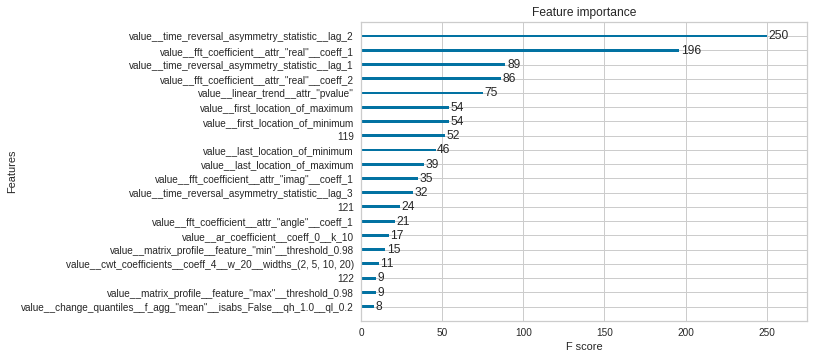

In [51]:
xgb.plot_importance(boost, max_num_features=20);

## Derived Features

In [52]:
boost = xgb.XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1, verbosity=3)

In [53]:
boost.fit(extracted_features_train, y_train, verbose=True)
pred = boost.predict(extracted_features_test)

[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=4
[14:09:37] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 

In [54]:
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1038
           2       0.99      1.00      0.99      1007
           3       0.99      0.99      0.99       989
           4       1.00      0.99      1.00       966

    accuracy                           0.99      4000
   macro avg       0.99      0.99      0.99      4000
weighted avg       0.99      0.99      0.99      4000



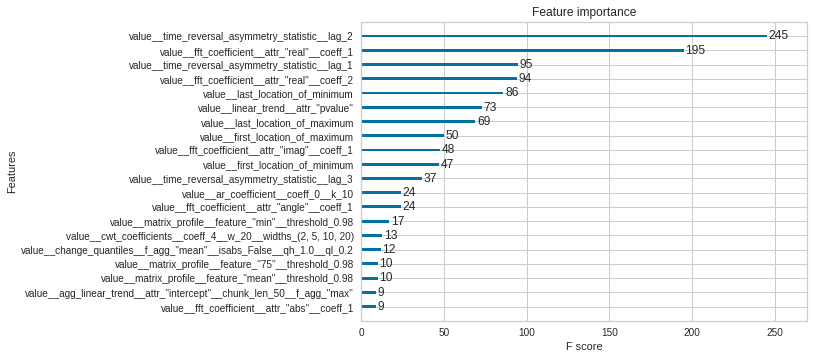

In [55]:
xgb.plot_importance(boost, max_num_features=20);

# Comparison

In [56]:
baseline = UCR_UEA_datasets().baseline_accuracy('TwoPatterns')['TwoPatterns']
baselineDF = pd.DataFrame(baseline, index=[0]).T
baselineDF.columns=['Accuracy']
baselineDF.sort_values('Accuracy', ascending=False)

,Accuracy
WDTW_1NN,1.00000
DTW_R1_1NN,1.00000
Flat-COTE,1.00000
EE,1.00000
DTW_F,1.00000
DD_DTW,1.00000
ERP_1NN,1.00000
HIVE-COTE,1.00000
DTD_C,0.99950
LCSS_1NN,0.99925
